# 더 나은 한영 번역기 만들기

## 라이브러리 선언

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.4.1


## 데이터 정제 및 토큰화

## 1) 데이터 불러오기 및 set 활용 중복 제거

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    print("중복 제거 전 길이 : {}".format(len(kor)))
    corpus = []
    for index in range(len(kor)) :
        corpus.append(kor[index] + '\t' + eng[index])
    
    cleaned_corpus = set(corpus)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)
print("중복 제거 후 길이 : {}".format(len(cleaned_corpus)))

중복 제거 전 길이 : 94123
중복 제거 후 길이 : 78968


In [4]:
#중복 제거후 set -> list로 다시 변환
cleaned_corpus = list(cleaned_corpus)

In [5]:
cleaned_corpus[:5]

['중국 정부는 현재 계속된 여진과 지진으로 자연 형성된 호수에 신경을 곤두세우고 있다.\tOne of China\'s main concerns after the May 12 earthquake is to deal with the effects of its aftershocks, with landslides having created dangerous "quake lakes."',
 '민주당 의원들은 2차 경기 부양책이 구제 금융 법안에 버금갈 정도로 많은 비용이 들더라도 추진해야 한다고 주장해 왔습니다만 백악관은 이에 냉담했습니다.\tCongressional Democrats have been pushing another jumpstart plan, even though it would be expensive, come on top of the financial bailout package, and the White House has been cool to the idea.',
 '중국 정부가 국제학교에서 망명을 요구하는 탈북자들을 북송한 것은 처음 있는 일이다.\tIt is the first time the Beijing regime has sent back North Koreans who sought asylum at international schools.',
 '두바노스키는 프리츨과 동명인 프리츨의 아들 요제프 프리츨이 지하실로 출입하는 것을 목격했으며 큰 아들인 프리츨이 주로 밤 에 지하실에 들어갔다고 말했다.\tDubanowsky said he saw Fritzl¡¯s son, also named Josef Fritzl, enter the cellar. He also saw the elder Fritzl enter the basement frequently at night.',
 '이 지원을 위해 담배 및 기타 담배 관련 제품에 대한 세금이 인상될 것이다.\tTaxes on cigarettes and other tobacco products wou

## 2) 데이터 전처리

In [6]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ?.!,]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence

## 3) 데이터 토크나이징

In [7]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
import sentencepiece as spm

def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]
    templates= '--input={} \
                --pad_id={} \
                --bos_id={} \
                --eos_id={} \
                --unk_id={} \
                --model_prefix={} \
                --vocab_size={} '
                

    if lang=="ko" :
        prefix = "kor_corpus"
        temp_file = os.getenv('HOME')+'/aiffel/GoingDeeper/Project05/kor_corpus'
    else :
        prefix = "eng_corpus"
        temp_file = os.getenv('HOME')+'/aiffel/GoingDeeper/Project05/eng_corpus'
    
    
    with open(temp_file, 'w') as f:
            for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
                f.write(str(row) + '\n')
    
    cmd = templates.format(temp_file,
                           pad_id,
                           bos_id,
                           eos_id,
                           unk_id,
                           prefix,
                           vocab_size)
       
    spm.SentencePieceTrainer.Train(cmd)
    sp = spm.SentencePieceProcessor()
    tokenizer = sp
    sp.Load('{}.model'.format(prefix))

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [8]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    # [[YOUR CODE]]
    tokens = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    if len(tokens) <= 50 :
        src_corpus.append(tokens)
        tokens_eng = en_tokenizer.EncodeAsIds(eng_corpus[idx])
        tgt_corpus.append(tokens_eng)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [9]:
enc_train[:5]

array([[   84,    54,     7,   135,  5568, 10034,    26,  2675,  2620,
         3172,    53,  4166,    12,  2588,     6,  8433,  1439,   333,
          403,    15,    25,     5,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [  244,  1649,     9,   254,   230,  6105,    14,  3015,   647,
         5355, 18362,  1462,   414,    19,   103,  3784,  1369,  3583,
           29,  1763,   228,   400,  9385,  8425,   112,   575,     9,
          299, 15769,   161,     5,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [   84,    54,    11,   307,  4441,    18,  2137,     6,  2570,
        13168,     6, 19122,    17,    39,     9,   212,    36,    22,
           86,     5,     0,     0,     0,     0,     0,    

In [10]:
dec_train[:5]

array([[    1,    68,    12,   161,    17,   407,   429,     5,    49,
            6,   181,  1412,    25,    10,   361,    27,     6,  1150,
            5,    12,    63,  3739,     5,     4,     8,    27,  2804,
            5,   732,    15,  1477,     9,  1737,  1710,  7024,     7,
            2,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

## 트랜스포머 모델 설계

1) positional_encoding  
2) multi-head attention  
3) Position-wise Feed-Forward Network  

In [11]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [13]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


## 트랜스포머 모델 조립

In [14]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


In [15]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [17]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [18]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [19]:
transformer = Transformer(2,512,8,2048,20000,20000,130)

## 기타 함수들

In [20]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [22]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

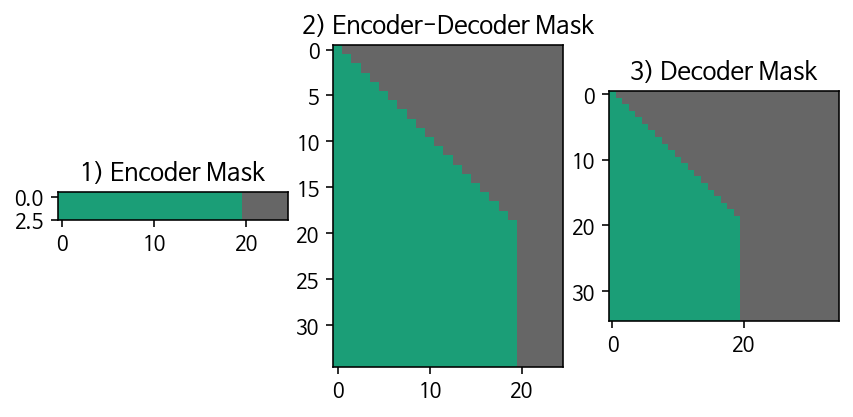

In [23]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

## 모델 학습

In [24]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    # [[YOUR CODE]]
    #batch_loss = (loss / int(tgt.shape[1]))

    variables = model.encoder.trainable_variables + model.decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [25]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [26]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [27]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [28]:
np.version.version

'1.19.5'

In [29]:
tf.__version__

'2.4.1'

In [30]:
# 학습

from tqdm.notebook import tqdm

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s obama , obama s .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are also be around .
Input: 커피는 필요 없다.
Predicted translation: it is a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they were , they were , , , , , , , , , , , , , , , about , , , , , , , , , , , , , , about about , , , , , about about about , , , , , , , , , , , , , and .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is expected to be the obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are also , which have been killed .
Input: 커피는 필요 없다.
Predicted translation: it is not a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on monday , the officials were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president , obama is a , obama s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are also , they are very , they are , they are , they are , they are , they are , they said .
Input: 커피는 필요 없다.
Predicted translation: it is not a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they were killed in the , they said .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first time obama is a .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are they are very good .
Input: 커피는 필요 없다.
Predicted translation: there s no one , he said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they said they were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first in the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re all they were taken .
Input: 커피는 필요 없다.
Predicted translation: it is not a .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they were killed in the southern city of a five day visit .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s campaign says he s a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were also known for the city .
Input: 커피는 필요 없다.
Predicted translation: they re not known .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president elect will meet the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re just trying to get around .
Input: 커피는 필요 없다.
Predicted translation: it s not known , you have to get a big .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was across the country .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were taken to the city .
Input: 커피는 필요 없다.
Predicted translation: they get to get the .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was taken to the day .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is in the coming .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just to the high .
Input: 커피는 필요 없다.
Predicted translation: it s not a . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll , which was about . million people .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s becoming president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just perform in the city .
Input: 커피는 필요 없다.
Predicted translation: the four calls on the right thing .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: five people were killed in the ljubics .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is a spice very close awa .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re just about .
Input: 커피는 필요 없다.
Predicted translation: you don t get a big .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people were killed in the area monday , which killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a very hard .
Input: 시민들은 도시 속에 산다.
Predicted translation: the other cities .
Input: 커피는 필요 없다.
Predicted translation: the coffee is a . won a . won .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll in the death toll was , which killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it s a very closemulate .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just then ad .
Input: 커피는 필요 없다.
Predicted translation: when you re in the end , they re doing feel , coffee said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , people were killed , without a week .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: they re president to the house .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re just over .
Input: 커피는 필요 없다.
Predicted translation: when you re not a step up .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , people were killed .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to be president of the senate on the politicalltz .
Input: 시민들은 도시 속에 산다.
Predicted translation: her crews , she is just a little girl in the street .
Input: 커피는 필요 없다.
Predicted translation: when you know you feel , the those people , you have to say that you won t call t .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , a dozen kunaes were able to armal


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is a serious coup .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the other for the cities .
Input: 커피는 필요 없다.
Predicted translation: the t amnes use is a need , coffee said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , people were killed , the death toll i .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is now president bush .
Input: 시민들은 도시 속에 산다.
Predicted translation: accommodations alsoeld .
Input: 커피는 필요 없다.
Predicted translation: the coffee is a need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , the hundreds were killed , people .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the obama campaign has said .
Input: 시민들은 도시 속에 산다.
Predicted translation: tavanta is one of the cities .
Input: 커피는 필요 없다.
Predicted translation: when theully is called the coffee bees , the nation is called the tribal leader .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , the homes were killed and others were , preferred sunday in the ljubics of firing on the main north of kat .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama to be president with the political turmoil .
Input: 시민들은 도시 속에 산다.
Predicted translation: unconditional trade just for the citing .
Input: 커피는 필요 없다.
Predicted translation: when you re not a man who late court , you won t have anmovic mount .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , the death toll is estimated as at least six people .


  0%|          | 0/1199 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama will be president in the political pediatric salo country .
Input: 시민들은 도시 속에 산다.
Predicted translation: her crews are she and then her at the same city .
Input: 커피는 필요 없다.
Predicted translation: when you re trying todayjail each other , you won t need to those .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on saturday night co star of the sealed hundreds of people were injured .


Input: 오바마는 대통령이다.
Predicted translation: obama will be president in the political pediatric salo country .
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


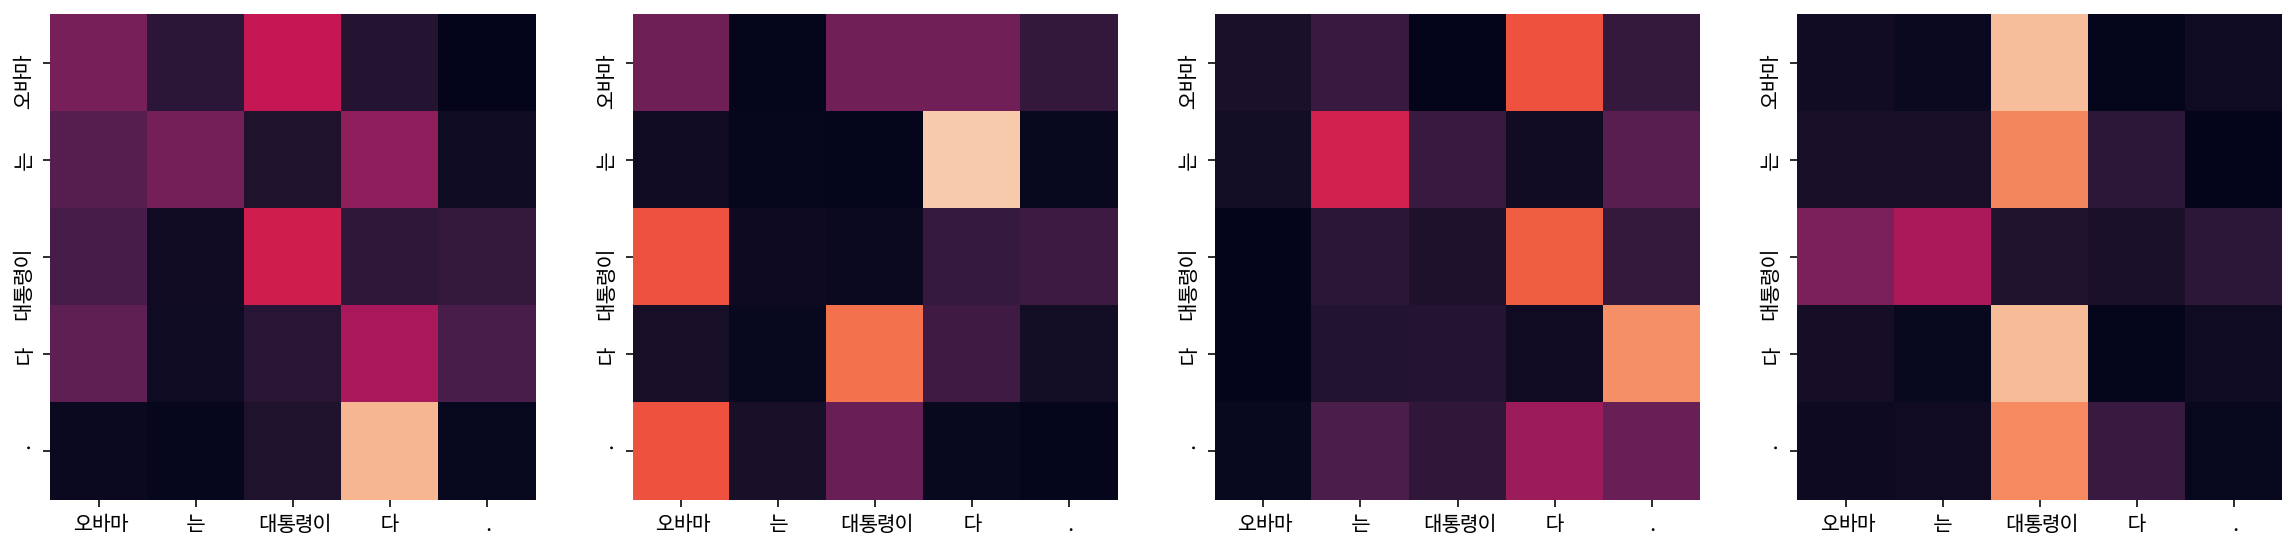

Encoder Layer 2


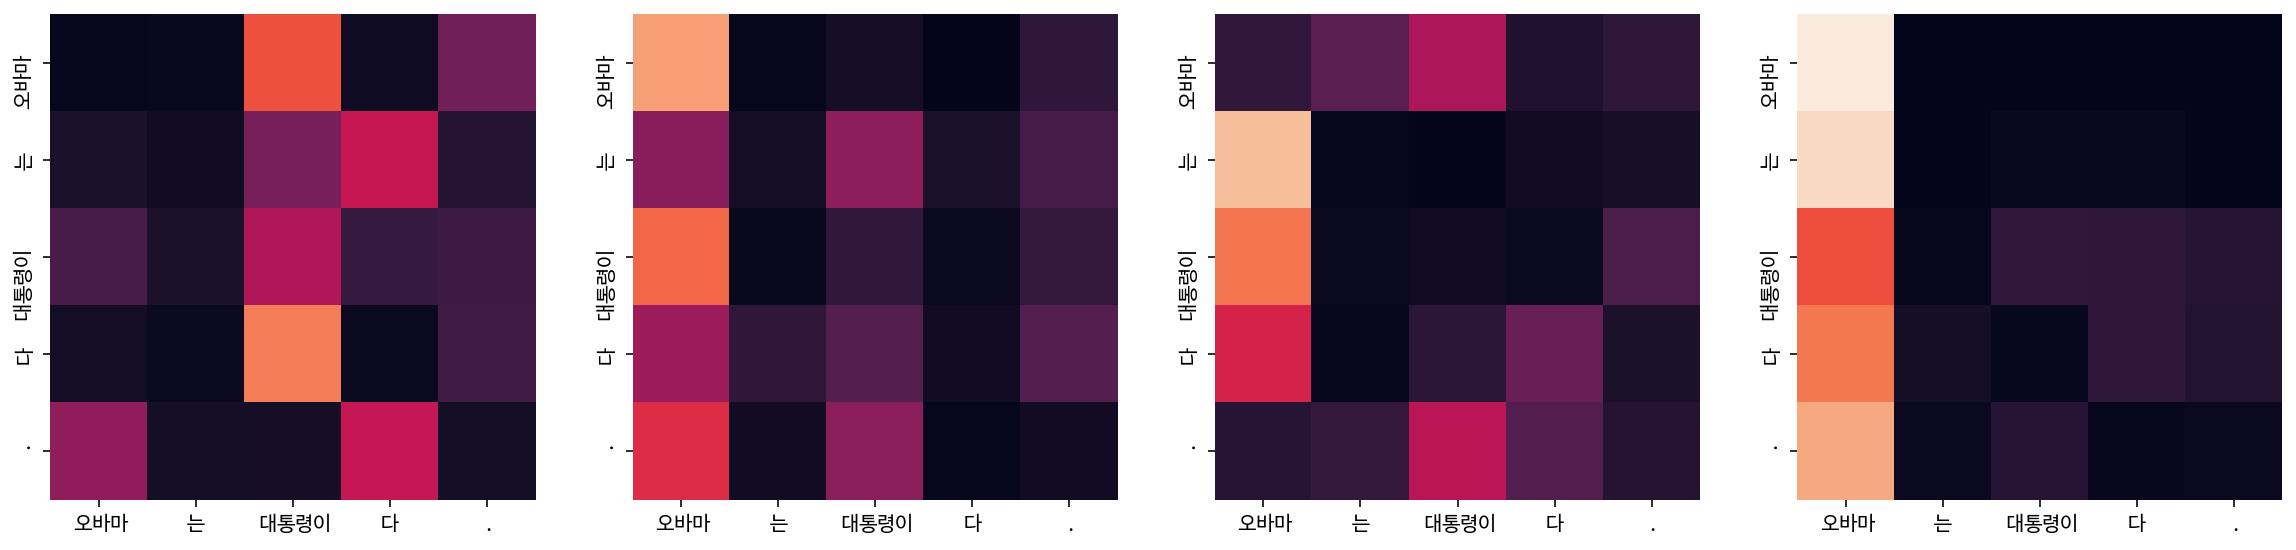

Decoder Self Layer 1


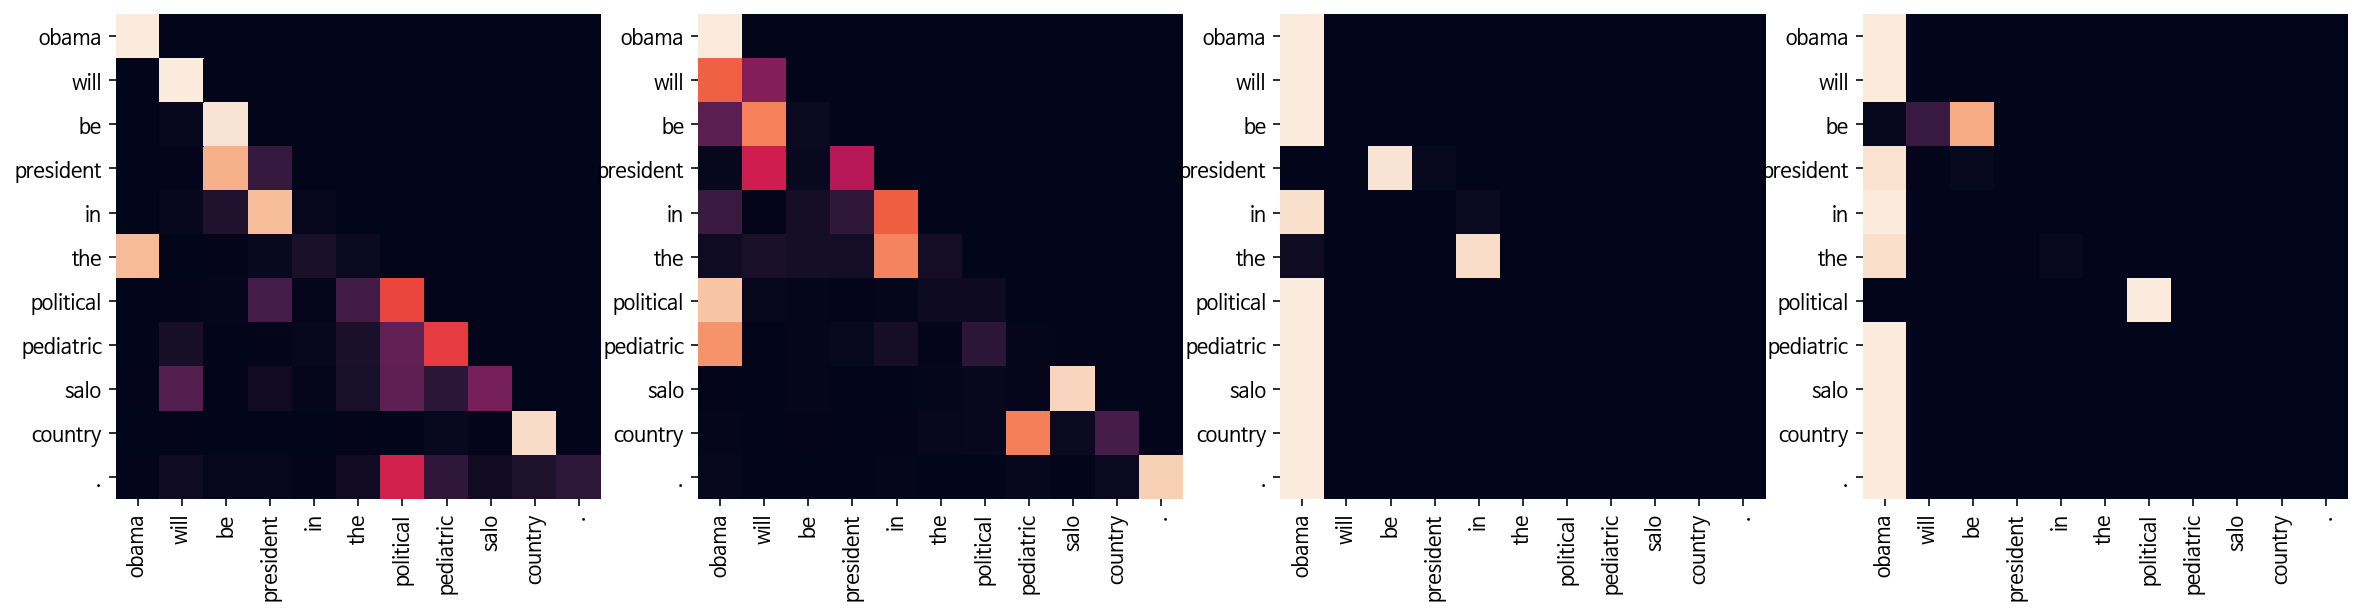

Decoder Src Layer 1


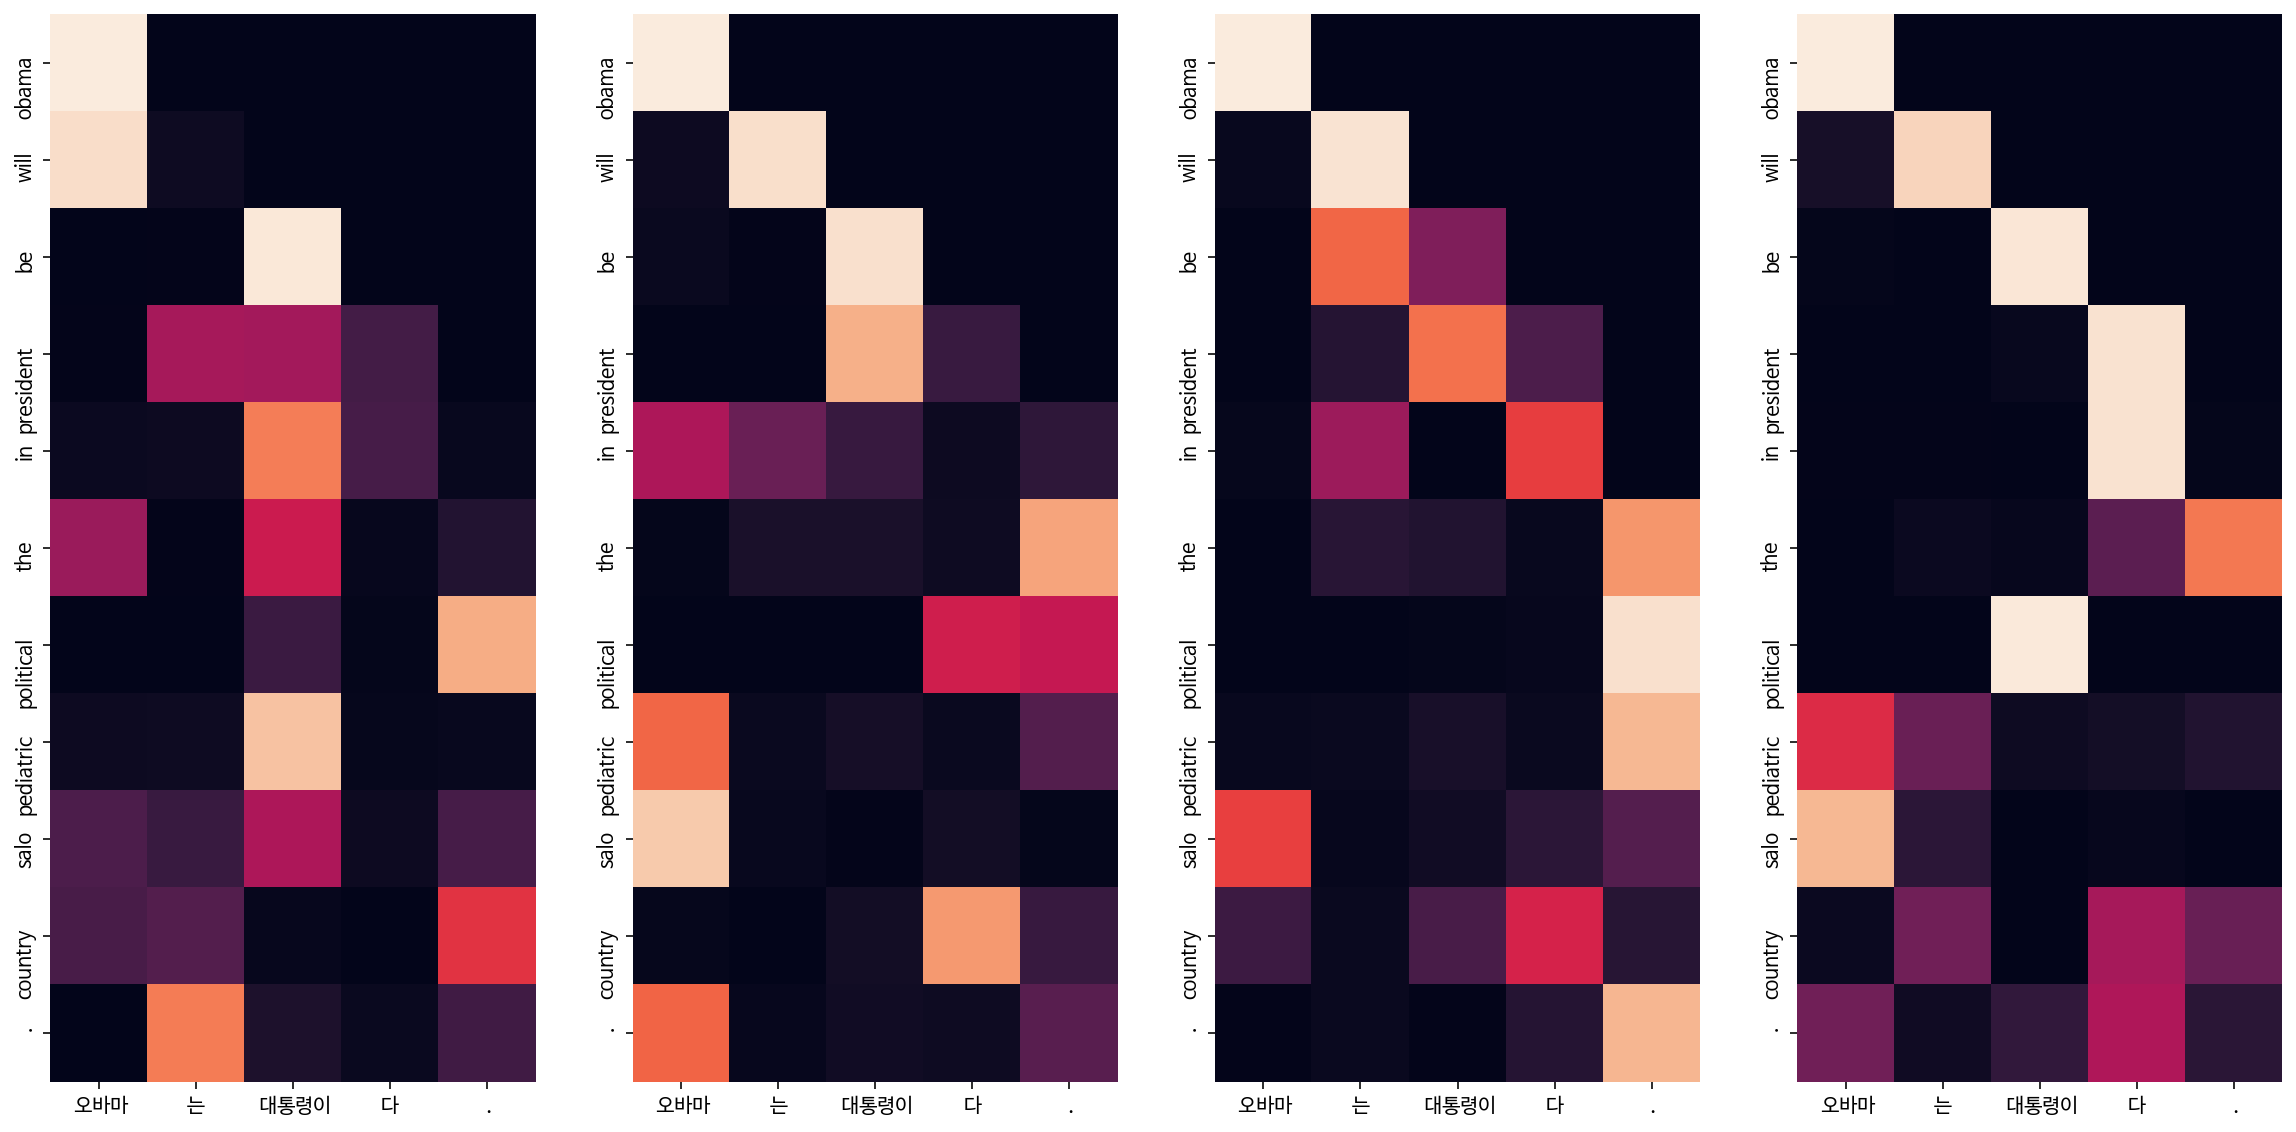

Decoder Self Layer 2


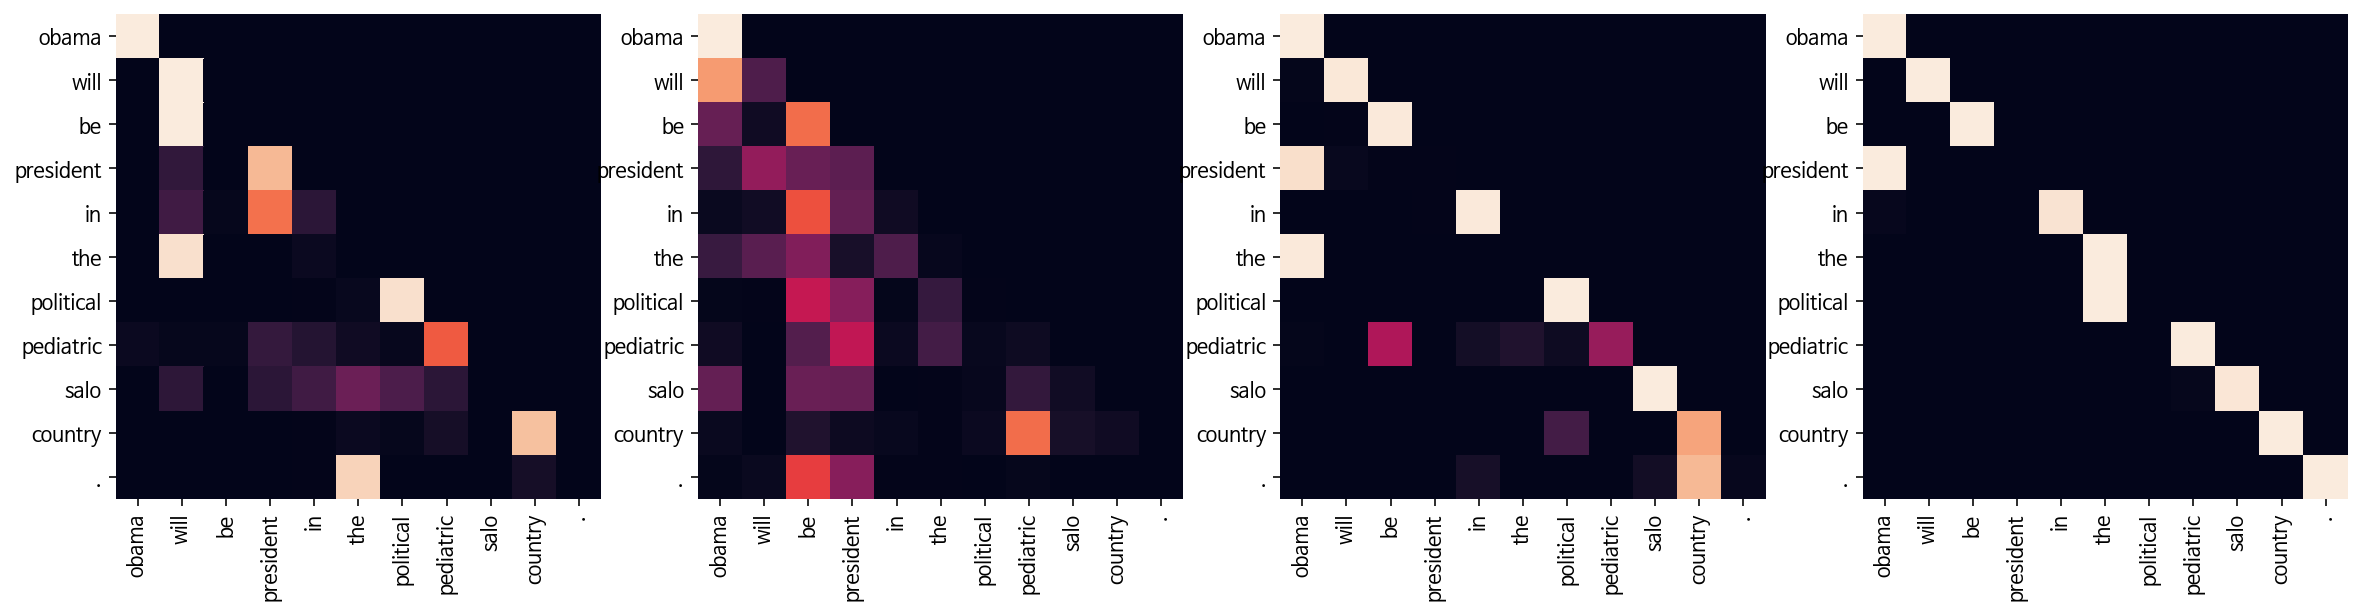

Decoder Src Layer 2


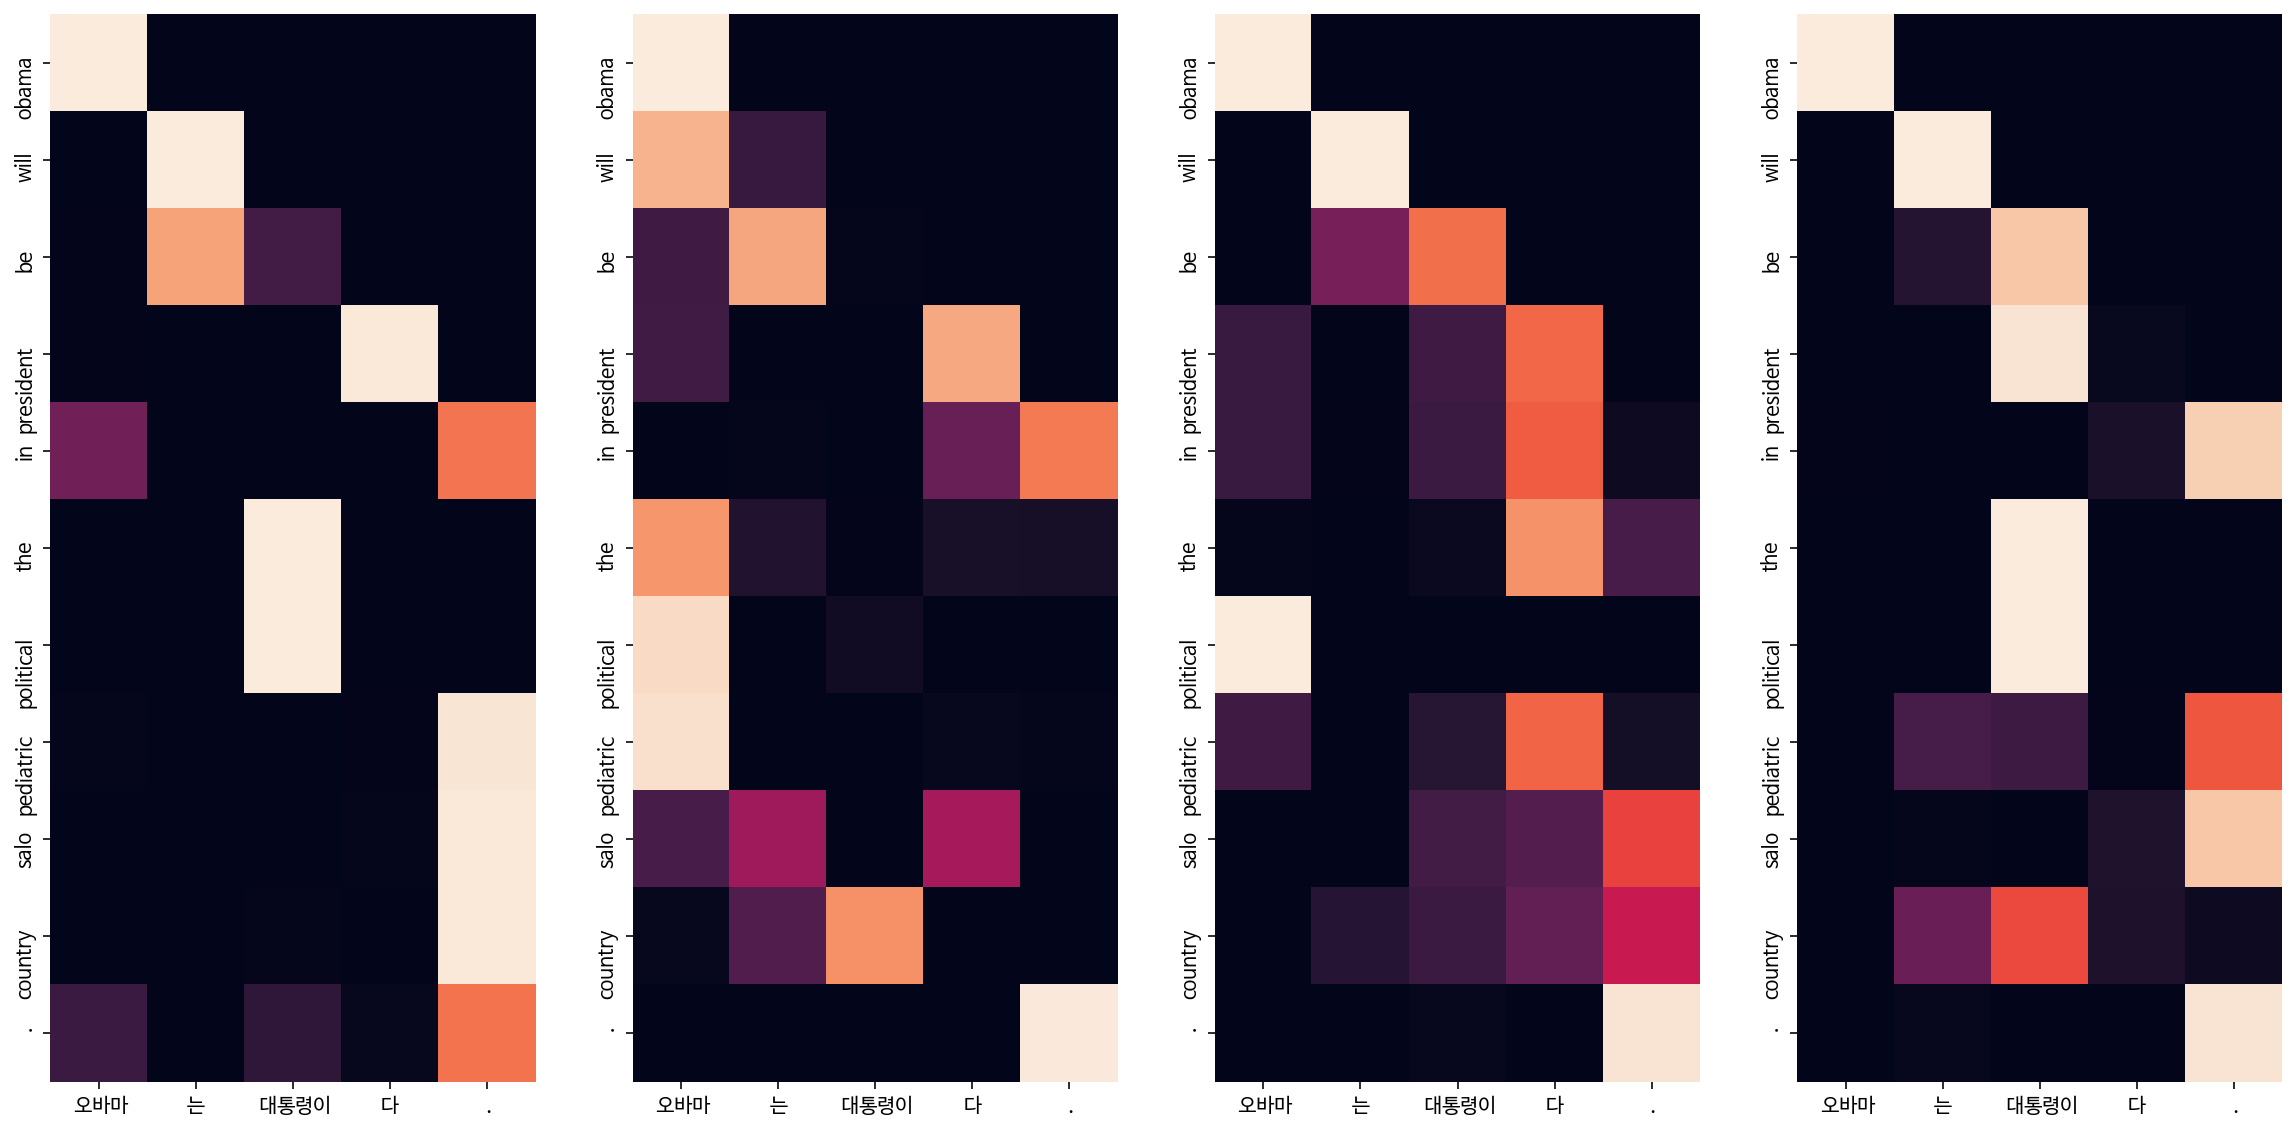

In [31]:
translate("오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Epoch 8  
Input: 오바마는 대통령이다.  
Predicted translation: obama is a president .  
  
Input: 시민들은 도시 속에 산다.  
Predicted translation: they were taken to the city .  
  
Epoch 11  
Input: 일곱 명의 사망자가 발생했다.  
Predicted translation: six people were killed in the area monday , which killed .  
  
Epoch 17  
Input: 커피는 필요 없다.  
Predicted translation: the coffee is a need .  

여전히 번역 결과가 만족스럽지만은 않지만,  
시퀀스 투 시퀀스 방식의 지난 프로젝트와 비하면 훨씬 비슷한 의미의 문장을 생성해주는 것을 확인할 수 있었습니다.  
전반적인 번역의 질은 Epoch 8~ 11정도에서 가장 좋았고 이후로 갈수록 오히려 질이 떨어지는 현상이 발생했습니다.  
반면 loss는 계속해서 감소했는데 validation loss를 확인할 수 있도록 코드를 짯다면 학습상황을 좀더 잘 확인할 수 있었을 것 같습니다.

  
이번 프로젝트에서는 주어진 베이스라인에서 만들되 많은부분을 직접 채워넣어야 했는데  
지금까지 코드 복붙에 익숙해져있던 저에게는 매우 힘들고 어려웠지만  
결국은 논문을 보고 구현하여 그럴싸한 수준까지 학습을 시킬 수 있어서 뿌듯합니다.  
